In [78]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 
import torch.optim as optim
from braingeneers.analysis import SpikeData
import os
import json
import pytorch_lightning as pl
from backbones import ResNet18Enc, ResNet18Dec
import wandb
import pickle

In [97]:
waveform_files = ["data/" + f for f in os.listdir("./data") if f.endswith('.npy')]
meta_files = [f.replace('.npy', '.json') for f in waveform_files]

waveforms = []
isi_dist = []

for wf, mf in zip(waveform_files, meta_files):
    waveforms.append(np.load(wf))
    
    with open(mf, 'r') as file:
        json_data = json.load(file)

    sd = SpikeData([json_data[key]['train'] for key in json_data.keys()])
    trains = sd.train

    all_isi = sd.interspike_intervals()
    
    for isi in all_isi:
        hist, edges = np.histogram(isi[isi < 2], bins=64, density=True)
        isi_dist.append(hist)

In [98]:
waveforms = np.concatenate(waveforms, axis=0)

In [99]:
isi_dist

[array([10.95918951,  5.47959475,  3.88137962,  1.59821514,  0.68494934,
         0.68494934,  0.4566329 ,  0.22831645,  0.22831645,  0.68494934,
         0.22831645,  0.        ,  0.4566329 ,  0.22831645,  0.22831645,
         0.22831645,  0.        ,  0.        ,  0.4566329 ,  0.22831645,
         0.68494934,  0.        ,  0.        ,  0.        ,  0.        ,
         0.22831645,  0.        ,  0.        ,  0.        ,  0.        ,
         0.22831645,  0.22831645,  0.22831645,  0.22831645,  0.        ,
         0.68494934,  0.4566329 ,  0.22831645,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.22831645,  0.22831645,
         0.22831645,  0.22831645,  0.22831645,  0.        ,  0.22831645,
         0.        ,  0.22831645,  0.        ,  0.22831645,  0.22831645,
         0.4566329 ,  0.22831645,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.4566329 ]),
 array([10.13191332,  2.99676309,  1.85513906,  0.57081202,  0

In [100]:
class EphysDataset(Dataset):
    def __init__(self, waveforms, isi_dists, normalize=True):
        self.waveforms = np.array(waveforms)
        self.isi_dists = np.array(isi_dists)
        
        assert len(self.waveforms) == len(self.isi_dists)
        self.normalize = normalize
        
    def __getitem__(self, idx):
        waveform = torch.as_tensor(self.waveforms[idx, ...]).float()
        
        isi_dist = torch.as_tensor(self.isi_dists[idx, ...]).float()
        isi_dist = torch.log(isi_dist + 1)

        if self.normalize:
            waveform = (waveform - waveform.mean()) / waveform.std()
            isi_dist = (isi_dist - isi_dist.mean()) / isi_dist.std()
            
        waveform = waveform.view(1, 1, -1)
        waveform = F.interpolate(waveform, size=(64,), mode='linear').view(1, -1)
        return waveform, isi_dist.unsqueeze(0)
    
    def __len__(self):
        return len(self.waveforms)

In [101]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)

        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss


In [102]:
class MixedModel(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        
        self.wave_encoder = ResNet18Enc(z_dim=z_dim)
        self.time_encoder = ResNet18Enc(z_dim=z_dim)

#         self.fc_wave = nn.Linear(z_dim*2, z_dim)
#         self.fc_time = nn.Linear(z_dim*2, z_dim)
        
#         self.norm1 = nn.BatchNorm1d(z_dim)
        
#         self.wave_upsample = nn.Linear(z_dim, z_dim*2)
#         self.time_upsample = nn.Linear(z_dim, z_dim*2)
        
        self.wave_decoder = ResNet18Dec(z_dim=z_dim)
        self.time_decoder = ResNet18Dec(z_dim=z_dim)
        
    def forward(self, wave, time):
        e_wave, e_time = self.wave_encoder(wave), self.time_encoder(time)
#         e_wave, e_time = self.fc_wave(e_wave), self.fc_time(e_time)
#         e_wave, e_time = self.norm1(e_wave), self.norm1(e_time)
        
#         d_wave, d_time = self.wave_upsample(e_wave), self.time_upsample(e_time)
        d_wave, d_time = self.wave_decoder(e_wave), self.time_decoder(e_time)

        return e_wave, e_time, d_wave, d_time

In [103]:
model = MixedModel(
    z_dim=5
)

sample = torch.randn(2, 8, 1, 64).unbind(0)

x,y,z,w = model(*sample)
x.shape, y.shape, z.shape, w.shape

(torch.Size([8, 10]),
 torch.Size([8, 10]),
 torch.Size([8, 1, 64]),
 torch.Size([8, 1, 64]))

In [104]:
from pytorch_lightning.utilities import grad_norm

class MultimodalEmbeddingModel(pl.LightningModule):
    def __init__(self, base_model, batch_size, contrastive_loss_weight=1.0):
        super().__init__()
        self.model = base_model
        self.contrastive_loss_weight = contrastive_loss_weight
        self.mse_loss = nn.MSELoss()
        self.contrastive_loss = ContrastiveLoss(batch_size, temperature=0.5)

    def training_step(self, batch, batch_idx):
        wave, time = batch
        rep_w, rep_t, decode_w, decode_t = self.model(wave, time)

        mse_loss_w = self.mse_loss(decode_w, wave)
        mse_loss_t = self.mse_loss(decode_t, time)
        mse_loss = mse_loss_w + mse_loss_t

        emb_i, emb_j = rep_w, rep_t
        contrastive_loss = self.contrastive_loss(emb_i, emb_j)

        # Combine losses
        total_loss = mse_loss + self.contrastive_loss_weight * contrastive_loss

        self.log('train_loss', total_loss)
        self.log('train_mse_loss', mse_loss)
        self.log('train_xe_loss', contrastive_loss)
        
        norms = grad_norm(self.model.wave_encoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.wave_decoder, norm_type=2)
        self.log_dict(norms)

        return total_loss

    def validation_step(self, batch, batch_idx):
        wave, time = batch
        rep_w, rep_t, decode_w, decode_t = self.model(wave, time)

        mse_loss_w = self.mse_loss(decode_w, wave)
        mse_loss_t = self.mse_loss(decode_t, time)
        mse_loss = mse_loss_w + mse_loss_t

        emb_i, emb_j = rep_w, rep_t
        contrastive_loss = self.contrastive_loss(emb_i, emb_j)

        # Combine losses
        total_loss = mse_loss + self.contrastive_loss_weight * contrastive_loss

        self.log('val_loss', total_loss)
        self.log('val_mse_loss', mse_loss)
        self.log('val_xe_loss', contrastive_loss)

        return total_loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.001)
        return optimizer


In [105]:
class UnimodalModel(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim)
        )
        
    def forward(self, x):
        enc_x = self.encoder(x)
        dec_x = self.decoder(enc_x)
        
        return enc_x, dec_x

class UnimodalEmbeddingModel(pl.LightningModule):
    def __init__(self, mode, base_model):
        super().__init__()
        assert mode in ("wave", "time")
        self.mode = mode
        self.model = base_model

        self.mse_loss = nn.MSELoss()

    def training_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        norms = grad_norm(self.model.encoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.decoder, norm_type=2)
        self.log_dict(norms)

        self.log('train_loss', loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.01)
        return optimizer

In [106]:
bs = 64
wf_train, isi_train = waveforms[:15000], isi_dist[:15000]
wf_val, isi_val = waveforms[15000:], isi_dist[15000:]

traindata = EphysDataset(wf_train, isi_train)
valdata = EphysDataset(wf_val, isi_val)

train_loader = DataLoader(traindata, batch_size=bs, drop_last=True)
val_loader = DataLoader(valdata, batch_size=bs, drop_last=True)

def train_unimodal_model(mode):
    wandb.init(reinit=True)

    base_model = UnimodalModel(z_dim=5)

    model = UnimodalEmbeddingModel(mode=mode, base_model=base_model)
    print("Training model")
    trainer = pl.Trainer(
        logger=pl.loggers.WandbLogger(),
        log_every_n_steps=5,
        max_epochs=5,
    )

    trainer.fit(model, train_loader, val_loader)
    
    return base_model

In [38]:
wave_model = train_unimodal_model("wave")

with open('wave_model.pkl', 'wb') as f:
    pickle.dump(wave_model, f)

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
grad_2.0_norm/0.bias,▁▁▃▃▁▁▂▂▁▁█▂▁▁▂▂▁▁▅▁▁▁▂▂▁▁▂▃▁▂▁▃▁▂▇▂▁▁▃▂
grad_2.0_norm/0.bn1.bias,▁▁▂▁▁▁▁▂▁▁▅▂▁▁▁▁▁▁▄▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁█▁▁▁▃▁
grad_2.0_norm/0.bn1.weight,▁▁▃▂▁▁▁▆▁▂▄▁▁▁▁▁▁▁▃▁▁▁▂▂▁▁▁▁▁▁▁▄▁▂█▂▁▁▃▁
grad_2.0_norm/0.conv1.weight,▁▁▄▂▁▁▂▅▁▂▃▁▁▁▁▁▁▁▃▁▁▁▁▂▁▁▁▁▁▁▁▄▁▂█▁▁▁▂▁
grad_2.0_norm/0.layer1.0.bn1.bias,▁▁▂▁▁▁▁▂▁▁▆▂▁▁▁▁▁▁▅▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁█▁▁▁▄▂
grad_2.0_norm/0.layer1.0.bn1.weight,▁▁▃▃▁▁▁▆▁▂▅▂▁▁▁▁▁▁▅▁▁▁▂▂▁▁▁▁▁▁▁▃▁▂█▂▁▁▄▂
grad_2.0_norm/0.layer1.0.bn2.bias,▁▁▂▁▁▁▁▂▁▁█▂▁▁▁▁▁▁▅▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▇▁▁▁▃▁
grad_2.0_norm/0.layer1.0.bn2.weight,▁▁▄▂▁▁▁▄▁▂▆▂▁▁▁▁▁▁▄▁▁▁▂▂▁▁▂▂▁▁▁▃▁▃█▂▁▁▃▂
grad_2.0_norm/0.layer1.0.conv1.weight,▁▁▆▃▁▁▁█▁▂▃▁▁▁▁▁▁▁▃▁▁▁▂▂▁▁▁▁▁▁▁▃▁▂▇▂▁▁▃▁
grad_2.0_norm/0.layer1.0.conv2.weight,▂▂█▃▁▁▂▆▁▂▄▁▁▁▁▁▁▁▄▁▁▁▂▂▁▁▁▁▁▁▁▃▁▂▅▁▁▁▃▂


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name     | Type          | Params
-------------------------------------------
0 | model    | UnimodalModel | 8.0 M 
1 | mse_loss | MSELoss       | 0     
-------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
32.182    Total estimated model params size (MB)


Training model
Sanity Checking DataLoader 0:  50%|██████████████████████████████████████████▌                                          | 1/2 [00:00<00:00,  6.50it/s]

/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:44<00:00,  1.04it/s, v_num=054j]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  35%|██████████████████████████████                                                         | 49/142 [00:08<00:16,  5.72it/s]


Validation DataLoader 0:  72%|█████████████████████████████████████████████████████████████▊                        | 102/142 [00:17<00:06,  5.78it/s]


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:49<00:00,  1.02it/s, v_num=054j]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|█████▌                                                                                  | 9/142 [00:01<00:19,  6.66it/s]


Validation DataLoader 0:  44%|█████████████████████████████████████▉                                                 | 62/142 [00:10<00:12,  6.20it/s]


Validation DataLoader 0:  81%|█████████████████████████████████████████████████████████████████████▋                | 115/142 [00:18<00:04,  6.27it/s]


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:27<00:00,  1.13it/s, v_num=054j]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  15%|█████████████▍                                                                         | 22/142 [00:03<00:17,  6.73it/s]


Validation DataLoader 0:  53%|█████████████████████████████████████████████▉                                         | 75/142 [00:11<00:10,  6.39it/s]


Validation DataLoader 0:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 128/142 [00:20<00:02,  6.33it/s]


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:23<00:00,  1.15it/s, v_num=054j]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|█████████████████████▍                                                                 | 35/142 [00:05<00:16,  6.38it/s]


Validation DataLoader 0:  62%|█████████████████████████████████████████████████████▉                                 | 88/142 [00:13<00:08,  6.57it/s]


Validation DataLoader 0:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 141/142 [00:21<00:00,  6.61it/s]


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:30<00:00,  1.11it/s, v_num=054j]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  34%|█████████████████████████████▍                                                         | 48/142 [00:08<00:15,  5.95it/s]


Validation DataLoader 0:  71%|█████████████████████████████████████████████████████████████▏                        | 101/142 [00:17<00:07,  5.82it/s]


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:54<00:00,  1.00it/s, v_num=054j]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:55<00:00,  1.00it/s, v_num=054j]


In [107]:
time_model = train_unimodal_model("time")

with open('isi_model.pkl', 'wb') as f:
    pickle.dump(time_model, f)

epoch,▁▁▁▂▂▂▂▃▃▃▃▅▅▅▆▆▆▆▁▁▁▂▂▂▂▃▃▃▅▅▅▅▆▆▆▇▇▇▇█
grad_2.0_norm/0.bias,▂▂▁█▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
grad_2.0_norm/0.bn1.bias,▁▃▁█▂▁▁▁▃▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.bn1.weight,▅▇▁█▂▁▁▁▇▁▃▁▆▁▄█▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▂▁▁
grad_2.0_norm/0.conv1.weight,▄▆▁▆▂▁▁▁▄▁▂▁▃▁▂█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn1.bias,▁▃▁█▂▁▁▁▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn1.weight,▄▄▁█▁▁▁▁▃▁▂▁▃▁▄▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn2.bias,▁▄▁█▂▁▁▁▁▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn2.weight,▄▆▁█▂▁▁▁▂▁▂▁▃▁▃▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▂▁▁▁▁
grad_2.0_norm/0.layer1.0.conv1.weight,▄▄▁█▁▁▁▁▂▁▁▁▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.conv2.weight,▆█▁█▁▁▁▁▂▁▂▁▃▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name     | Type          | Params
-------------------------------------------
0 | model    | UnimodalModel | 8.0 M 
1 | mse_loss | MSELoss       | 0     
-------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
32.182    Total estimated model params size (MB)


Training model
Sanity Checking DataLoader 0:   0%|                                                                                             | 0/2 [00:00<?, ?it/s]

/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:51<00:00,  1.01it/s, v_num=bjs7]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  35%|██████████████████████████████                                                         | 49/142 [00:08<00:15,  6.00it/s]


Validation DataLoader 0:  72%|█████████████████████████████████████████████████████████████▊                        | 102/142 [00:17<00:06,  5.72it/s]


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 234/234 [04:11<00:00,  0.93it/s, v_num=bjs7]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|█████▌                                                                                  | 9/142 [00:01<00:23,  5.64it/s]


Validation DataLoader 0:  44%|█████████████████████████████████████▉                                                 | 62/142 [00:10<00:14,  5.69it/s]


Validation DataLoader 0:  81%|█████████████████████████████████████████████████████████████████████▋                | 115/142 [00:19<00:04,  5.80it/s]


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [04:25<00:00,  0.88it/s, v_num=bjs7]
Validation: |                                                                                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|███████████████                                                                                                                                                                                                                              | 9/142 [00:02<00:36,  3.69it/s]


Validation DataLoader 0:  25%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                | 36/142 [00:07<00:23,  4.52it/s]


Validation DataLoader 0:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 63/142 [00:14<00:17,  4.46it/s]


Validation DataLoader 0:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 90/142 [00:19<00:11,  4.62it/s]


Validation DataLoader 0:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 117/142 [00:25<00:05,  4.60it/s]


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:44<00:00,  1.04it/s, v_num=bjs7]
Validation: |                                                                                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]


Validation DataLoader 0:  18%|█████████████████████████████████████████▌                                                                                                                                                                                                  | 25/142 [00:03<00:17,  6.61it/s]


Validation DataLoader 0:  37%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 52/142 [00:07<00:13,  6.71it/s]


Validation DataLoader 0:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 79/142 [00:13<00:10,  5.82it/s]


Validation DataLoader 0:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 106/142 [00:17<00:06,  5.93it/s]


Validation DataLoader 0:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 133/142 [00:22<00:01,  5.88it/s]


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:12<00:00,  1.21it/s, v_num=bjs7]
Validation: |                                                                                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|███████████████████████▎                                                                                                                                                                                                                    | 14/142 [00:02<00:19,  6.60it/s]


Validation DataLoader 0:  29%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 41/142 [00:06<00:15,  6.60it/s]


Validation DataLoader 0:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 68/142 [00:10<00:10,  6.77it/s]


Validation DataLoader 0:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 95/142 [00:13<00:06,  6.87it/s]


Validation DataLoader 0:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 122/142 [00:17<00:02,  6.82it/s]


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:33<00:00,  1.09it/s, v_num=bjs7]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [03:33<00:00,  1.09it/s, v_num=bjs7]


In [ ]:
wandb.init(reinit=True)
base_model = MixedModel(z_dim=5)

with open('wave_model.pkl', 'rb') as f:
    wave_model = pickle.load(f)

with open('isi_model.pkl', 'rb') as f:
    time_model = pickle.load(f)

# copy over encoder
base_model.wave_encoder = wave_model.encoder
base_model.time_encoder = time_model.encoder

# copy over decoder
base_model.wave_decoder = wave_model.decoder
base_model.time_decoder = time_model.decoder

model = MultimodalEmbeddingModel(base_model=base_model, contrastive_loss_weight=0.5, batch_size=bs)

trainer = pl.Trainer(
    logger=pl.loggers.WandbLogger(name='multimodal training'),
    log_every_n_steps=5,
)

trainer.fit(model, train_loader, val_loader)

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
grad_2.0_norm/0.bias,▂▃▄█▃▃▇▃▂▃▂▃▇▂▂▂▂▁▂▁█▃▄▂▃▂▂▃▄▂▂▂▂▄▁▄▃▂▄▃
grad_2.0_norm/0.bn1.bias,█▄▄▂▅▂▄▄▁▃▁▂▅▃▃▃▂▂▁▂▄▂▃▃▃▄▂▃▆▄▃▁▂▃▁▅▂▄▂▃
grad_2.0_norm/0.bn1.weight,█▄▅▂▇▂▃▄▁▅▂▃▄▃▆▄▂▃▂▂▇▂▅▄▃▄▂▂▅▅▃▂▂▄▂▄▄▅▅▃
grad_2.0_norm/0.conv1.weight,█▄▄▂▃▂▃▄▁▃▁▂▃▂▄▃▁▂▁▁▅▁▃▃▂▃▂▂▂▂▂▁▁▃▁▂▃▃▂▂
grad_2.0_norm/0.layer1.0.bn1.bias,█▃▄▂▃▂▄▃▁▂▁▂▅▂▃▃▂▂▁▂▃▂▂▄▃▄▂▃▄▄▁▁▂▂▁▄▃▂▂▂
grad_2.0_norm/0.layer1.0.bn1.weight,█▃▅▂▅▂▄▅▁▂▁▂▃▃▄▂▁▁▁▂▃▂▂▂▃▂▂▁▃▂▁▂▁▂▁▃▃▃▃▂
grad_2.0_norm/0.layer1.0.bn2.bias,█▄▅▂▃▂▄▃▁▃▁▂▆▃▃▄▂▃▁▂▄▂▄▅▃▄▃▃▄▆▂▁▂▃▂▄▄▂▂▃
grad_2.0_norm/0.layer1.0.bn2.weight,█▄▅▂▄▃▂▅▁▂▁▂▄▃▄▄▁▂▂▂▄▁▄▄▃▃▂▂▄▂▁▂▁▃▁▃▄▂▃▃
grad_2.0_norm/0.layer1.0.conv1.weight,█▃▄▂▃▂▃▃▁▂▁▂▂▂▃▂▁▂▁▁▃▂▂▂▂▂▁▁▂▂▁▁▁▂▁▂▂▂▂▂
grad_2.0_norm/0.layer1.0.conv2.weight,█▃▄▂▃▂▂▃▁▂▁▁▂▂▂▂▁▁▁▁▂▁▂▂▂▂▁▁▂▁▁▁▁▂▁▂▂▁▂▁


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name             | Type            | Params
-----------------------------------------------------
0 | model            | MixedModel      | 16.1 M
1 | mse_loss         | MSELoss         | 0     
2 | contrastive_loss | ContrastiveLoss | 0     
-----------------------------------------------------
16.1 M    Trainable params
0   

Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                  | 0/2 [00:00<?, ?it/s]

/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0:  30%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 70/234 [01:50<04:17,  0.64it/s, v_num=jw8s]

In [64]:
from copy import deepcopy
joint_model = deepcopy(model)

In [60]:
with open('joint_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [61]:
model

MultimodalEmbeddingModel(
  (model): MixedModel(
    (wave_encoder): Sequential(
      (0): ResNet18Enc(
        (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (layer1): Sequential(
          (0): BasicBlockEnc(
            (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (shortcut): Sequential()
          )
          (1): BasicBlockEnc(
            (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [110]:
import matplotlib.pyplot as plt

def plot_waveforms_grid(data):
    N, C = data.shape
    ncols = 4
    nrows = -(-N // ncols)  # Ceiling division to calculate number of rows
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
    axs = axs.flatten()

    for i in range(N):
        axs[i].plot(data[i])
#         axs[i].axis('off')

#     for i in range(N, nrows * ncols):
#         axs[i].axis('off')

    plt.tight_layout()
    plt.show()


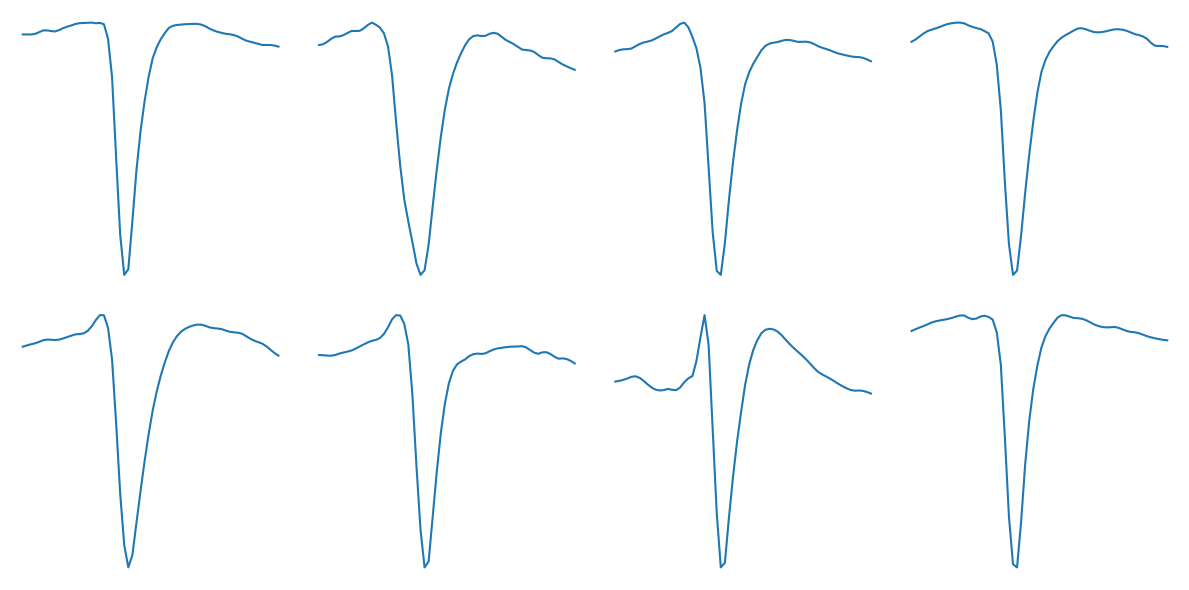

In [42]:
sample = next(iter(train_loader))[0].squeeze(1)[0:8, ...]

plot_waveforms_grid(sample)

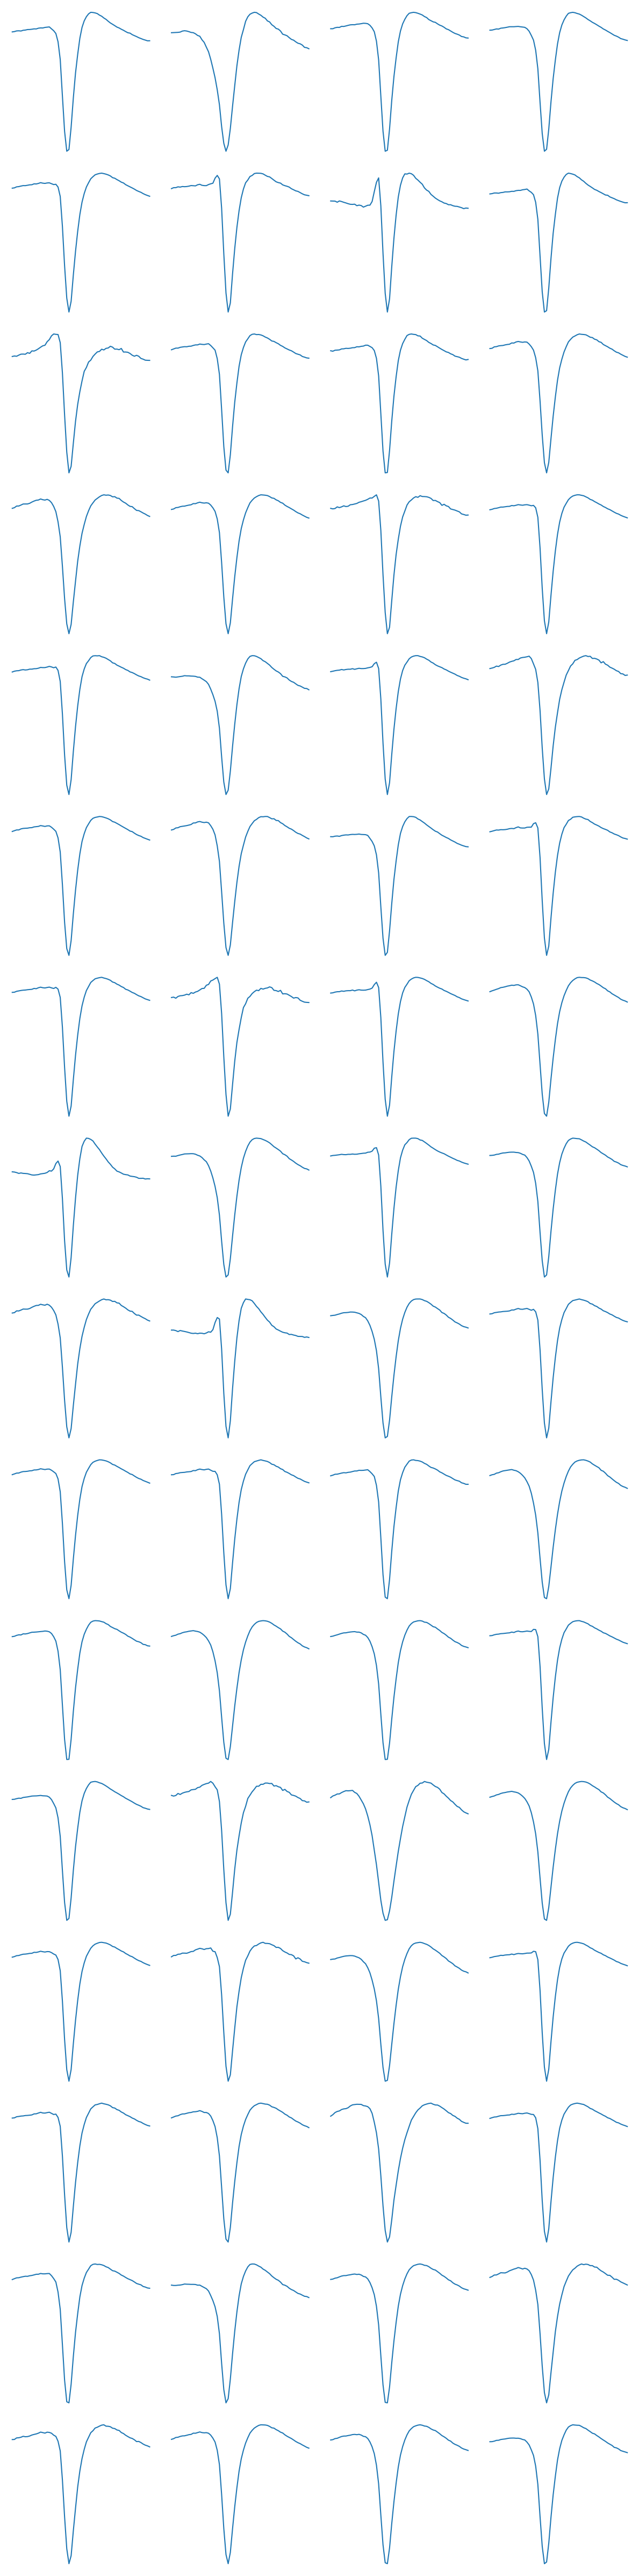

In [58]:
dec = wave_model(next(iter(train_loader))[0])
plot_waveforms_grid(dec[-1].squeeze(1).detach())

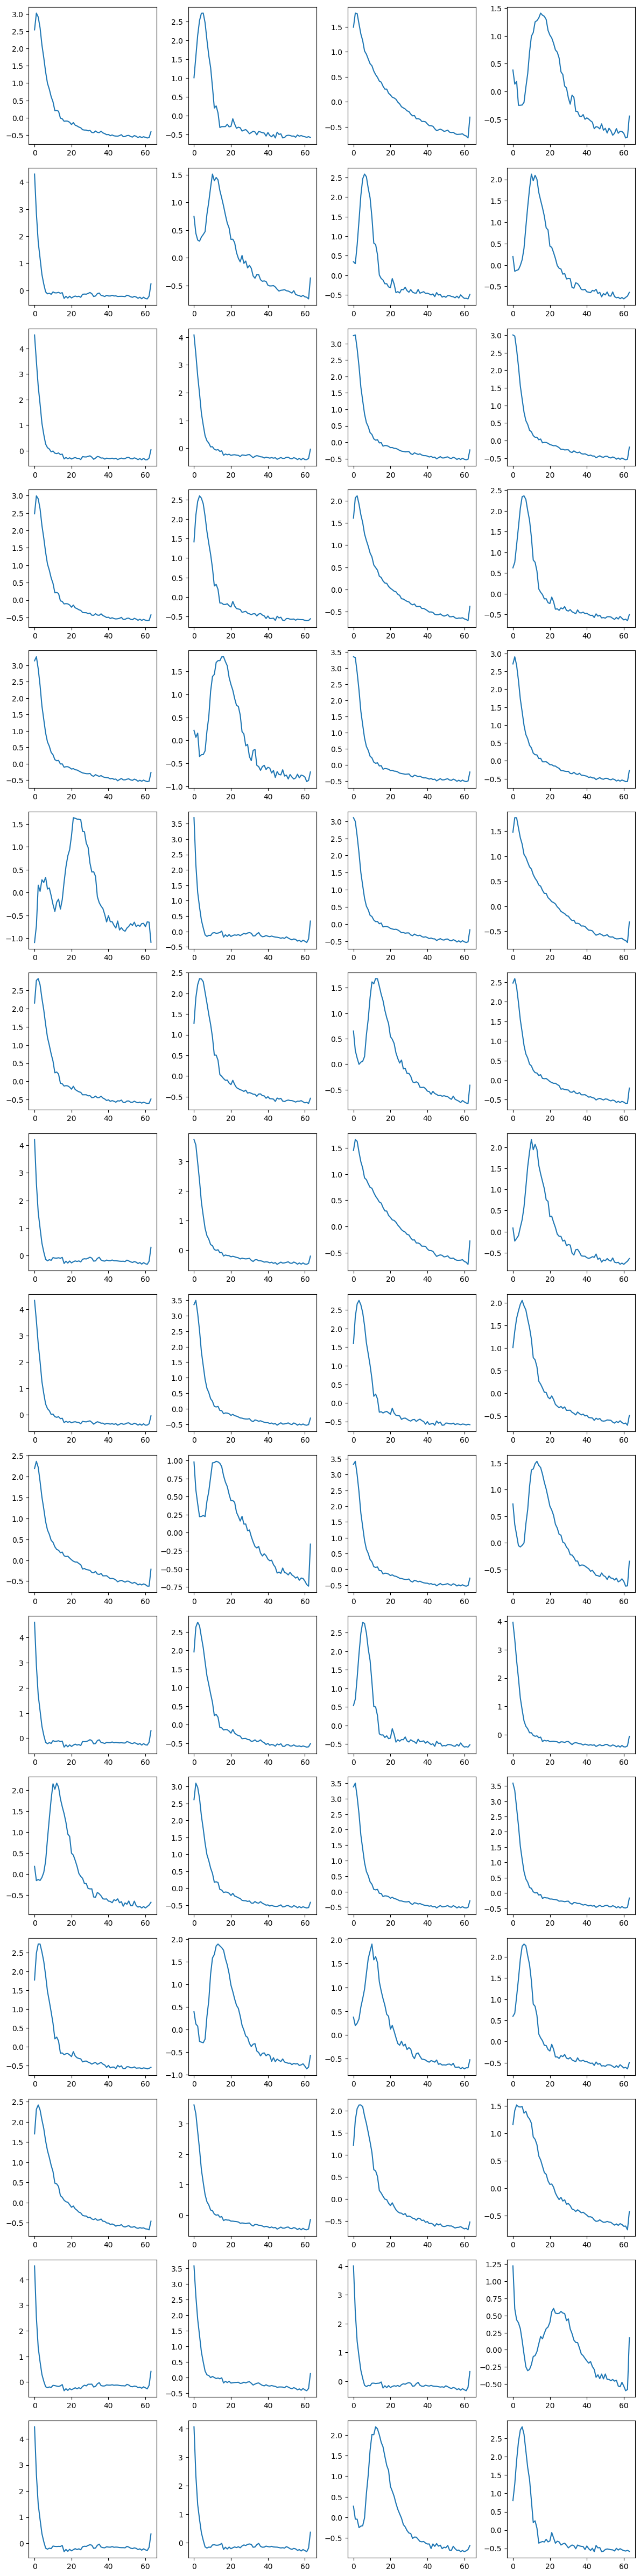

In [112]:
dec = time_model(next(iter(val_loader))[1])
plot_waveforms_grid(dec[-1].squeeze(1).detach())

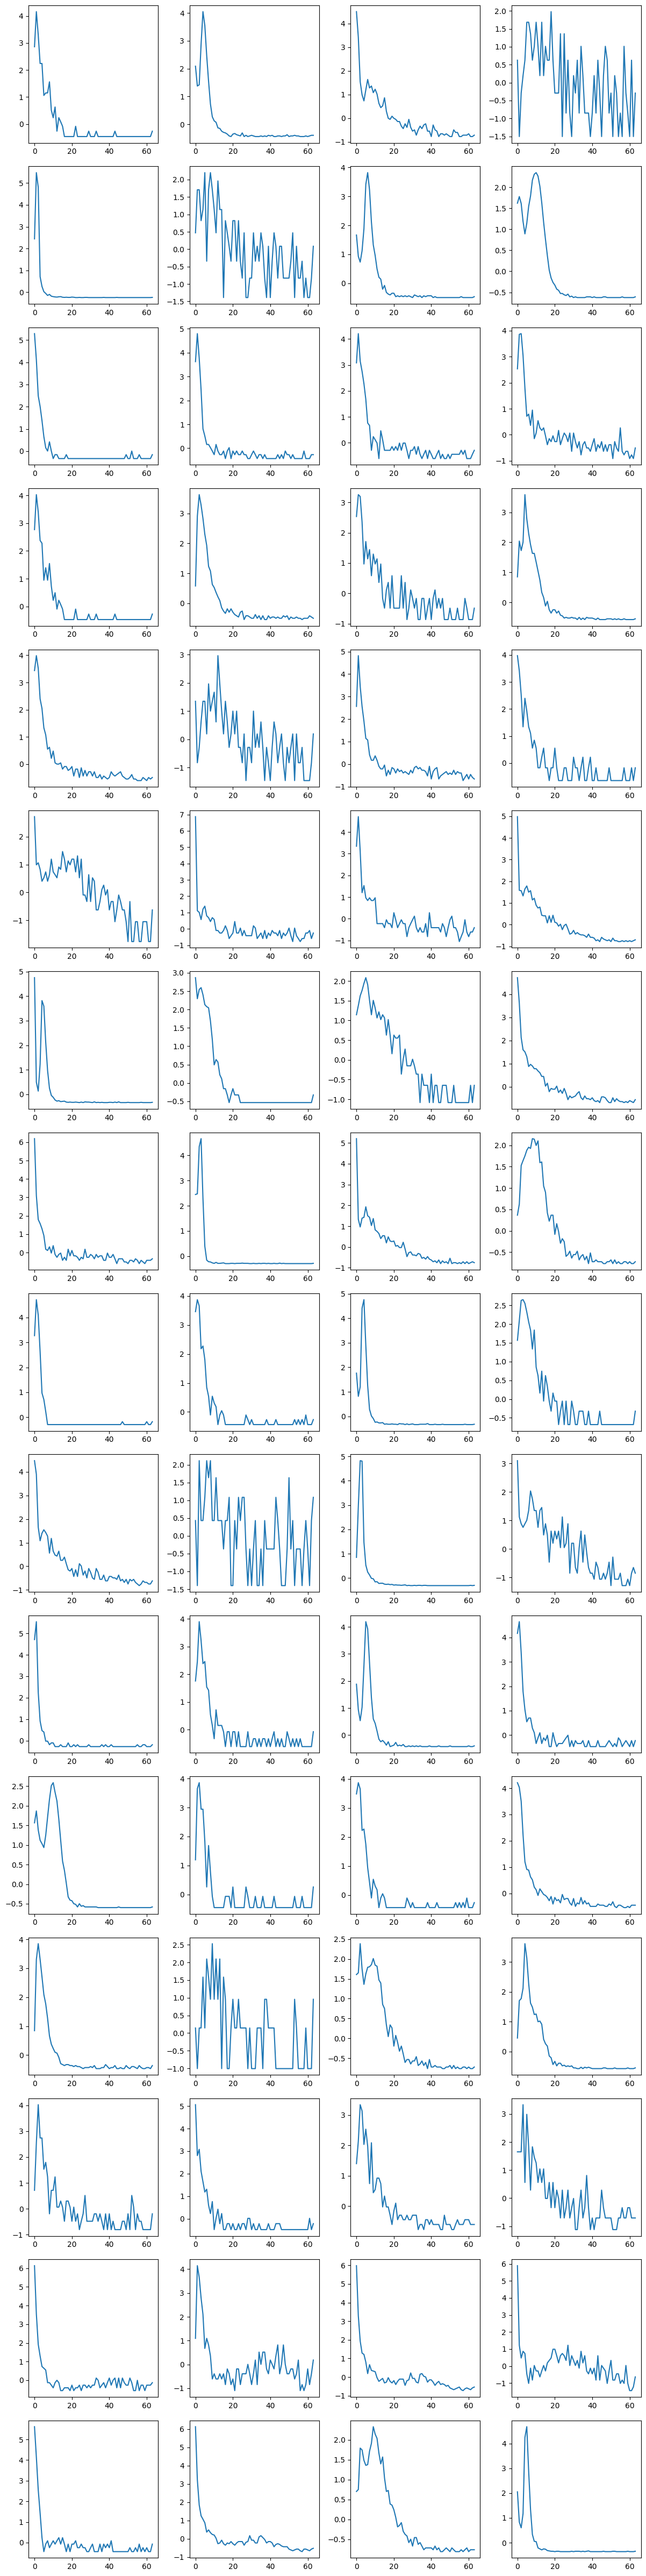

In [113]:
plot_waveforms_grid(next(iter(val_loader))[1].squeeze(1))